# Azure Custom Vision - Image classification prediction

This project leverages **Azure Custom Vision** to build and deploy a tailored image classification model.
We will build, train and deploy an image model classification to classify metal defects.
A gradio webapp is also available to predict the images.

## 🚀 Overview
**Azure Custom Vision** enables rapid creation of custom image classifiers using a simple web interface or API. It supports:
- **Multi-class classification**: Assigning one label per image.
- **Multi-label classification**: Assigning multiple labels per image.

## 🛠️ How It Works

- **Upload and Tag Images**: Use the portal or API to upload training images and assign tags.
- **Train the Model**: Azure uses transfer learning to train a model based on your dataset.
- **Evaluate Performance**: Review precision, recall, confusion matrix and accuracy metrics.
- **Deploy**: Publish the model as a REST API or export it for offline use (Onnx, Docker, TensorFlow, CoreML).

## 📚 Resources
- https://learn.microsoft.com/en-us/azure/ai-services/custom-vision-service/overview
- https://learn.microsoft.com/en-us/azure/ai-services/custom-vision-service/getting-started-build-a-classifier

<img src="screenshot.jpg">

In [1]:
#%pip install azure-cognitiveservices-vision-customvision

In [2]:
import datetime
import gradio as gr
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

from azurecv import AzureCustomVisionImageClassifier
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from dotenv import load_dotenv
from msrest.authentication import ApiKeyCredentials
from PIL import Image

In [3]:
sys.version

'3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]'

In [4]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 15-Sep-2025 08:46:47


## 1. Settings

In [5]:
load_dotenv("azure.env")

training_endpoint = os.environ["training_endpoint"]  # Training endpoint for Azure Custom Vision
prediction_endpoint = os.environ["prediction_endpoint"]  # Prediction endpoint for Azure Custom Vision
training_key = os.environ["training_key"]  # Training key for Azure Custom Vision
prediction_key = os.environ["prediction_key"]  # Prediction key for Azure Custom Vision
prediction_resource_id = os.environ["prediction_resource_id"]  # Prediction resource id

In [6]:
# Trainer
training_credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(training_endpoint, training_credentials)

# Predictor
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(prediction_endpoint, prediction_credentials)

In [7]:
OUTPUT_DIR = "results"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [8]:
IMAGES_DIR = "images"

TRAIN_DIR = os.path.join(IMAGES_DIR, "train")
TEST_DIR = os.path.join(IMAGES_DIR, "test")

### Deployed model to use

In [9]:
project_id = "c7989390-651a-4a1f-a68c-466b8b45d6ab"
iteration_id = "d04c61f7-17d7-4400-9705-9b3a4dcc4d4d"

In [10]:
publish_iteration_name = "Iteration2"

## 2. Helper

In [11]:
def display_detailed_performance_metrics():
    """📊 Display comprehensive performance metrics for all models"""
    try:
        projects = trainer.get_projects()

        for project in projects:
            print(f"\n{'='*60}")
            print(f"📁 PROJECT: {project.name}")
            print(f"{'='*60}")

            iterations = trainer.get_iterations(project.id)
            completed_iterations = [
                iter for iter in iterations if iter.status == "Completed"
            ]

            if not completed_iterations:
                print(
                    "⚠️ No completed models found for performance evaluation.")
                continue

            print("\033[1;31;34m")
            for iteration in completed_iterations:
                print(f"\n🤖 Model: {iteration.name}")
                print(f"📌 Status: {iteration.status}")
                print(f"🕒 Created: {iteration.created}")
                print("-" * 40)

                try:
                    # Get overall performance
                    performance = trainer.get_iteration_performance(
                        project.id, iteration.id)

                    print("📈 OVERALL PERFORMANCE:")
                    print(
                        f"  🎯 Precision = {performance.precision:.4f} ({performance.precision:.2%})"
                    )
                    print(
                        f"  🔍 Recall = {performance.recall:.4f} ({performance.recall:.2%})"
                    )
                    print(
                        f"  📊 Average Precision (AP) = {performance.average_precision:.4f} ({performance.average_precision:.2%})"
                    )

                    # Get per-tag performance
                    if hasattr(performance, 'per_tag_performance'
                               ) and performance.per_tag_performance:
                        print("\n🏷️ PER-TAG PERFORMANCE:")
                        for tag_perf in performance.per_tag_performance:
                            print(f"  🏷️ Tag: {tag_perf.name}")
                            print(
                                f"    🎯 Precision = {tag_perf.precision:.4f} ({tag_perf.precision:.2%})"
                            )
                            print(
                                f"    🔍 Recall = {tag_perf.recall:.4f} ({tag_perf.recall:.2%})"
                            )
                            print(
                                f"    📊 Average Precision = {tag_perf.average_precision:.4f} ({tag_perf.average_precision:.2%})"
                            )
                            print()

                    # Get precision/recall threshold data if available
                    if hasattr(performance, 'precision_recall_curve'):
                        print("📉 PRECISION-RECALL CURVE DATA:")
                        for i, point in enumerate(
                                performance.precision_recall_curve[:5]
                        ):  # Show first 5 points
                            print(
                                f"  🔸 Point {i+1}: Precision={point.precision:.3f}, Recall={point.recall:.3f}, Threshold={point.threshold:.3f}"
                            )
                        if len(performance.precision_recall_curve) > 5:
                            print(
                                f"  ➕ ... and {len(performance.precision_recall_curve) - 5} more points"
                            )

                except Exception as e:
                    print(f"❌ Could not retrieve performance metrics: {e}")

                print("-" * 40)

    except Exception as e:
        print(f"❌ Error: {e}")

In [12]:
def display_performance_for_specific_model(project_id, iteration_id):
    """📊 Display detailed performance for a specific model"""
    try:
        # Get project info
        project = trainer.get_project(project_id)
        iteration = trainer.get_iteration(project_id, iteration_id)

        print(f"📁 PROJECT: {project.name}")
        print(f"🤖 MODEL: {iteration.name}")

        performance = trainer.get_iteration_performance(
            project_id, iteration_id)

        # Overall metrics
        print("\033[1;31;34m")
        print("📈 OVERALL PERFORMANCE METRICS:")
        print(f"  🎯 Precision = {performance.precision:.6f}")
        print(f"  🔍 Recall = {performance.recall:.6f}")
        print(
            f"  📊 Average Precision (mAP) = {performance.average_precision:.6f}"
        )
        f1_score = 2 * (performance.precision * performance.recall) / (
            performance.precision + performance.recall)
        print(f"  🧮 F1 Score = {f1_score:.6f}")

        # Per-tag performance
        if hasattr(performance,
                   'per_tag_performance') and performance.per_tag_performance:
            print(
                f"\n🏷️ PER-TAG PERFORMANCE ({len(performance.per_tag_performance)} tags):"
            )
            print(
                f"{'🏷️ Tag Name':<20} {'🎯 Precision':<10} {'🔍 Recall':<10} {'📊 AP':<10} {'🧮 F1':<10}"
            )

            for tag_perf in performance.per_tag_performance:
                f1 = 2 * (tag_perf.precision * tag_perf.recall) / (
                    tag_perf.precision + tag_perf.recall) if (
                        tag_perf.precision + tag_perf.recall) > 0 else 0
                print(
                    f"{tag_perf.name:<20} {tag_perf.precision:<10.4f} {tag_perf.recall:<10.4f} {tag_perf.average_precision:<10.4f} {f1:<10.4f}"
                )

        # Confusion matrix data (if available)
        try:
            print("\n📊 ADDITIONAL INFORMATIONS:")
            print(f"  🧬 Model Type: {project.settings.classification_type}")
            print(f"  🌐 Domain: {project.settings.domain_id}")
            if hasattr(iteration, 'training_time_in_milliseconds'):
                print(
                    f"  ⏱️ Training Time: {iteration.training_time_in_milliseconds / 1000:.1f} seconds"
                )
        except:
            pass

    except Exception as e:
        print(f"❌ Error retrieving performance metrics: {e}")

In [13]:
def compare_model_performance(project_id):
    """Compare performance across all models in a project"""
    try:
        project = trainer.get_project(project_id)
        iterations = trainer.get_iterations(project_id)
        completed_iterations = [
            iter for iter in iterations if iter.status == "Completed"
        ]

        print("\033[1;31;34m")
        print(f"PERFORMANCE COMPARISON - PROJECT: {project.name}")
        print("=" * 80)
        print(
            f"{'Model Name':<25} {'Precision':<12} {'Recall':<12} {'AP':<12} {'F1':<12} {'Created':<20}"
        )
        print("-" * 80)

        performance_data = []

        for iteration in completed_iterations:
            try:
                performance = trainer.get_iteration_performance(
                    project_id, iteration.id)
                f1 = 2 * (performance.precision * performance.recall) / (
                    performance.precision + performance.recall) if (
                        performance.precision + performance.recall) > 0 else 0

                performance_data.append({
                    'name':
                    iteration.name,
                    'precision':
                    performance.precision,
                    'recall':
                    performance.recall,
                    'ap':
                    performance.average_precision,
                    'f1':
                    f1,
                    'created':
                    iteration.created.strftime('%Y-%m-%d %H:%M')
                })

                print(
                    f"{iteration.name:<25} {performance.precision:<12.4f} {performance.recall:<12.4f} {performance.average_precision:<12.4f} {f1:<12.4f} {iteration.created.strftime('%Y-%m-%d %H:%M'):<20}"
                )

            except Exception as e:
                print(
                    f"{iteration.name:<25} {'Error':<12} {'Error':<12} {'Error':<12} {'Error':<12} {iteration.created.strftime('%Y-%m-%d %H:%M'):<20}"
                )

        # Find best performing model
        if performance_data:
            best_model = max(performance_data, key=lambda x: x['f1'])
            print(
                f"\nBEST PERFORMING MODEL (by F1 Score): {best_model['name']}")
            print(f"F1 Score: {best_model['f1']:.4f}")

    except Exception as e:
        print(f"❌ Error: {e}")

In [14]:
def export_results(project_id, output_file="performance_metrics.json"):
    """Export all performance metrics to JSON file"""
    try:
        project = trainer.get_project(project_id)
        iterations = trainer.get_iterations(project_id)

        project_data = {
            'project_name': project.name,
            'project_id': project_id,
            'models': []
        }

        for iteration in iterations:
            if iteration.status == "Completed":
                try:
                    performance = trainer.get_iteration_performance(
                        project_id, iteration.id)

                    model_data = {
                        'model_name': iteration.name,
                        'model_id': iteration.id,
                        'created': iteration.created.isoformat(),
                        'status': iteration.status,
                        'overall_performance': {
                            'precision': float(performance.precision),
                            'recall': float(performance.recall),
                            'average_precision': float(performance.average_precision)
                        }
                    }

                    # Add per-tag performance if available
                    if hasattr(performance, 'per_tag_performance') and performance.per_tag_performance:
                        model_data['per_tag_performance'] = []
                        for tag_perf in performance.per_tag_performance:
                            model_data['per_tag_performance'].append({
                                'tag_name': tag_perf.name,
                                'precision': float(tag_perf.precision),
                                'recall': float(tag_perf.recall),
                                'average_precision': float(tag_perf.average_precision)
                            })

                    project_data['models'].append(model_data)

                except Exception as e:
                    print(f"Error processing model {iteration.name}: {e}")

        # Save to JSON file
        output_filepath = os.path.join(OUTPUT_DIR, output_file)
        with open(output_filepath, 'w') as f:
            json.dump(project_data, f, indent=2)

        print(f"Performance metrics exported to {output_filepath}")
        !ls $output_filepath -lh
        return output_filepath

    except Exception as e:
        print(f"❌ Error exporting performance metrics: {e}")
        return None

In [15]:
def classify_image(image_path):
    """
    Classifies an image and returns a list of results sorted by descending probability.

    Returns:
        List of dictionaries with tag name and probability, sorted by probability.
    """
    results_list = []

    try:
        with open(image_path, "rb") as image_contents:
            results = predictor.classify_image(project_id,
                                               publish_iteration_name,
                                               image_contents.read())

            print(
                f"🖼️ Image classification results of image file '{image_path}'"
            )
            for prediction in results.predictions:
                result = {
                    "tag": prediction.tag_name,
                    "probability": prediction.probability
                }
                results_list.append(result)

        # Sort the results by probability in descending order
        sorted_results = sorted(results_list,
                                key=lambda x: x["probability"],
                                reverse=True)

        for result in sorted_results:
            print(f"🏷️ {result['tag']} = {result['probability']}")

        print()
        return sorted_results

    except Exception as e:
        print(f"❌ Error classifying image: {e}")
        return []

In [16]:
def view_predictions():
    """
    Visualizes image classification predictions using a horizontal bar chart.

    This function extracts tags and their associated probabilities from a global
    `results` list of dictionaries, where each dictionary contains a 'tag' and
    a 'probability' key. It then generates a horizontal bar chart using Matplotlib
    to display the prediction probabilities for each tag.
    """
    tags = [item['tag'] for item in results]
    probabilities = [item['probability'] for item in results]

    plt.figure(figsize=(10, 5))
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(tags)))
    bars = plt.barh(tags, probabilities, color=colors, height=0.6, alpha=0.8)

    for i, (bar, prob) in enumerate(zip(bars, probabilities)):
        plt.text(bar.get_width() + 0.01,
                 bar.get_y() + bar.get_height() / 2,
                 f'{prob:.3f}',
                 va='center',
                 ha='left',
                 fontsize=10)

    plt.xlabel('Probability', fontsize=10)
    plt.ylabel('Classification', fontsize=10)
    plt.title('Image Classification Results',
              fontsize=12,
              pad=20)
    plt.xlim(0, max(probabilities) * 1.15)
    plt.grid(axis='x', linestyle='--', alpha=0.3, color='gray')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.subplots_adjust(left=0.2)
    plt.gca().set_facecolor('#fafafa')

    plt.show()

## Model

In [17]:
project = trainer.get_project(project_id)
print("\033[1;31;34m")
print(f"📝 Azure Custom Vision Project Name: {project.name}")
print(f"🆔 Project ID: {project.id}")
print(f"📄 Project Description: {project.description}")
print(f"🏷️ Classification Type: {project.settings.classification_type}")
print(f"🎯 Domain: {project.settings.domain_id}")
print(f"📅 Created: {project.created}")
print(f"⏰ Last Modified: {project.last_modified}")


📝 Azure Custom Vision Project Name: metal-classification
🆔 Project ID: c7989390-651a-4a1f-a68c-466b8b45d6ab
📄 Project Description: Metal classification demo using Azure AI Custom Vision
🏷️ Classification Type: Multiclass
🎯 Domain: 2e37d7fb-3a54-486a-b4d6-cfc369af0018
📅 Created: 2025-09-14 13:25:31.763000+00:00
⏰ Last Modified: 2025-09-14 13:25:31.763000+00:00


In [18]:
display_detailed_performance_metrics()


📁 PROJECT: metal-classification


🤖 Model: Iteration 2
📌 Status: Completed
🕒 Created: 2025-09-14 13:26:48.763000+00:00
----------------------------------------
📈 OVERALL PERFORMANCE:
  🎯 Precision = 1.0000 (100.00%)
  🔍 Recall = 0.9875 (98.75%)
  📊 Average Precision (AP) = 1.0000 (100.00%)

🏷️ PER-TAG PERFORMANCE:
  🏷️ Tag: Crazing
    🎯 Precision = 1.0000 (100.00%)
    🔍 Recall = 1.0000 (100.00%)
    📊 Average Precision = 1.0000 (100.00%)

  🏷️ Tag: Inclusion
    🎯 Precision = 1.0000 (100.00%)
    🔍 Recall = 0.9750 (97.50%)
    📊 Average Precision = 1.0000 (100.00%)

  🏷️ Tag: Patches
    🎯 Precision = 1.0000 (100.00%)
    🔍 Recall = 1.0000 (100.00%)
    📊 Average Precision = 1.0000 (100.00%)

  🏷️ Tag: Pitted
    🎯 Precision = 1.0000 (100.00%)
    🔍 Recall = 0.9750 (97.50%)
    📊 Average Precision = 1.0000 (100.00%)

  🏷️ Tag: Rolled
    🎯 Precision = 1.0000 (100.00%)
    🔍 Recall = 1.0000 (100.00%)
    📊 Average Precision = 1.0000 (100.00%)

  🏷️ Tag: Scratches
    🎯 Precision = 1.

In [19]:
display_performance_for_specific_model(project_id, iteration_id)

📁 PROJECT: metal-classification
🤖 MODEL: Iteration 2

📈 OVERALL PERFORMANCE METRICS:
  🎯 Precision = 1.000000
  🔍 Recall = 0.987500
  📊 Average Precision (mAP) = 1.000000
  🧮 F1 Score = 0.993711

🏷️ PER-TAG PERFORMANCE (6 tags):
🏷️ Tag Name          🎯 Precision 🔍 Recall   📊 AP       🧮 F1      
Crazing              1.0000     1.0000     1.0000     1.0000    
Inclusion            1.0000     0.9750     1.0000     0.9873    
Patches              1.0000     1.0000     1.0000     1.0000    
Pitted               1.0000     0.9750     1.0000     0.9873    
Rolled               1.0000     1.0000     1.0000     1.0000    
Scratches            1.0000     0.9750     1.0000     0.9873    

📊 ADDITIONAL INFORMATIONS:
  🧬 Model Type: Multiclass
  🌐 Domain: 2e37d7fb-3a54-486a-b4d6-cfc369af0018


In [20]:
compare_model_performance(project_id)


PERFORMANCE COMPARISON - PROJECT: metal-classification
Model Name                Precision    Recall       AP           F1           Created             
--------------------------------------------------------------------------------
Iteration 2               1.0000       0.9875       1.0000       0.9937       2025-09-14 13:26    
Iteration 1               1.0000       0.9792       0.9999       0.9895       2025-09-14 13:25    

BEST PERFORMING MODEL (by F1 Score): Iteration 2
F1 Score: 0.9937


In [21]:
json_results = export_results(project_id)

Performance metrics exported to results/performance_metrics.json
-rwxrwxrwx 1 root root 2.5K Sep 15 08:46 results/performance_metrics.json


In [22]:
print("\033[1;31;34m")
with open(json_results, 'r') as f:
    print(f.read())


{
  "project_name": "metal-classification",
  "project_id": "c7989390-651a-4a1f-a68c-466b8b45d6ab",
  "models": [
    {
      "model_name": "Iteration 2",
      "model_id": "d04c61f7-17d7-4400-9705-9b3a4dcc4d4d",
      "created": "2025-09-14T13:26:48.763000+00:00",
      "status": "Completed",
      "overall_performance": {
        "precision": 1.0,
        "recall": 0.9875,
        "average_precision": 1.0
      },
      "per_tag_performance": [
        {
          "tag_name": "Crazing",
          "precision": 1.0,
          "recall": 1.0,
          "average_precision": 1.0
        },
        {
          "tag_name": "Inclusion",
          "precision": 1.0,
          "recall": 0.975,
          "average_precision": 1.0
        },
        {
          "tag_name": "Patches",
          "precision": 1.0,
          "recall": 1.0,
          "average_precision": 1.0
        },
        {
          "tag_name": "Pitted",
          "precision": 1.0,
          "recall": 0.975,
          "average_pr

In [23]:
# Get all tags in the project
tags = trainer.get_tags(project_id)
print(f"\nTotal tags = {len(tags)}\n")

for tag in tags:
    print(f"🏷️  Tag: {tag.name:<10} ID: {tag.id:<8} Number = {tag.image_count:>2}")


Total tags = 6

🏷️  Tag: Crazing    ID: b42257ae-d4d4-40ce-b56c-9a89f4f9a7d5 Number = 200
🏷️  Tag: Patches    ID: f4e57bc7-d484-4310-b46d-c48ec3cccaf0 Number = 200
🏷️  Tag: Rolled     ID: f89d3735-a521-46ba-8254-cad5762cbabe Number = 200
🏷️  Tag: Pitted     ID: 88ad6093-816f-4dec-baa7-cdab69d632a4 Number = 200
🏷️  Tag: Inclusion  ID: 3f5ad3c0-e061-494d-81fa-e20ac496d132 Number = 200
🏷️  Tag: Scratches  ID: cf51aebe-5fed-47ac-bc49-e9919ffe5846 Number = 200


## Predictions

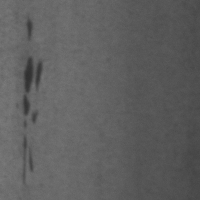

In [24]:
image_file = os.path.join(TEST_DIR, "Inclusion", "in_261.jpg")

img = Image.open(image_file)
display(img)

In [25]:
results = classify_image(image_file)

🖼️ Image classification results of image file 'images/test/Inclusion/in_261.jpg'
🏷️ Inclusion = 0.9986714
🏷️ Patches = 0.0007324194
🏷️ Pitted = 0.00045772502
🏷️ Crazing = 9.2741444e-05
🏷️ Scratches = 4.5222412e-05
🏷️ Rolled = 4.526258e-07



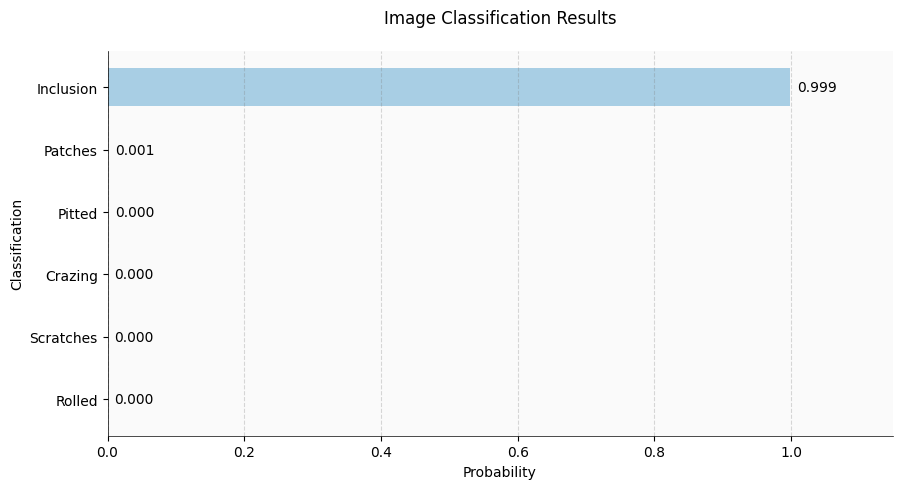

In [26]:
view_predictions()

In [27]:
print(f"Predicted tag is '{results[0]['tag']}' with score = {results[0]['probability']}")

Predicted tag is 'Inclusion' with score = 0.9986714


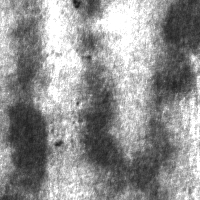

In [28]:
image_file = os.path.join(TEST_DIR, "Patches", "pa_261.jpg")
img = Image.open(image_file)
display(img)

In [29]:
results = classify_image(image_file)

🖼️ Image classification results of image file 'images/test/Patches/pa_261.jpg'
🏷️ Patches = 0.9999808
🏷️ Pitted = 1.5032425e-05
🏷️ Crazing = 2.4417016e-06
🏷️ Rolled = 1.715571e-06
🏷️ Inclusion = 5.124282e-09
🏷️ Scratches = 4.7786335e-09



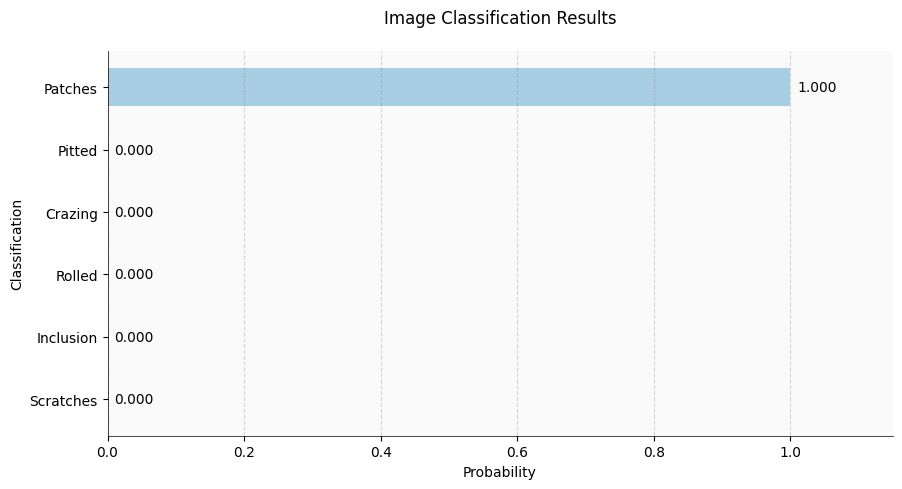

In [30]:
view_predictions()

In [31]:
print(f"Predicted tag is '{results[0]['tag']}' with score = {results[0]['probability']}")

Predicted tag is 'Patches' with score = 0.9999808


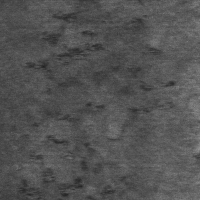

In [32]:
image_file = os.path.join(TEST_DIR, "Rolled", "rs_270.jpg")
img = Image.open(image_file)
display(img)

In [33]:
results = classify_image(image_file)

🖼️ Image classification results of image file 'images/test/Rolled/rs_270.jpg'
🏷️ Rolled = 0.9723795
🏷️ Patches = 0.018555613
🏷️ Crazing = 0.008904329
🏷️ Inclusion = 8.414729e-05
🏷️ Pitted = 7.618629e-05
🏷️ Scratches = 2.8782512e-07



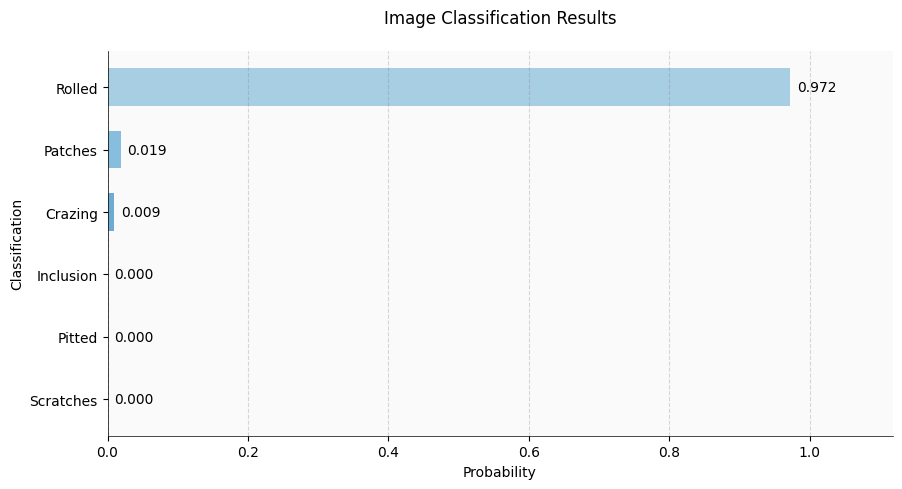

In [34]:
view_predictions()

In [35]:
print(f"Predicted tag is '{results[0]['tag']}' with score = {results[0]['probability']}")

Predicted tag is 'Rolled' with score = 0.9723795


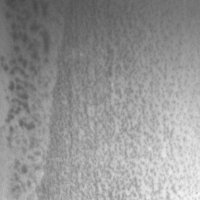

In [36]:
image_file = os.path.join(TEST_DIR, "Pitted", "pi_261.jpg")
img = Image.open(image_file)
display(img)

In [37]:
results = classify_image(image_file)

🖼️ Image classification results of image file 'images/test/Pitted/pi_261.jpg'
🏷️ Pitted = 1.0
🏷️ Inclusion = 1.5733825e-08
🏷️ Patches = 9.957245e-10
🏷️ Crazing = 4.4570983e-10
🏷️ Scratches = 2.2643896e-10
🏷️ Rolled = 1.0815122e-10



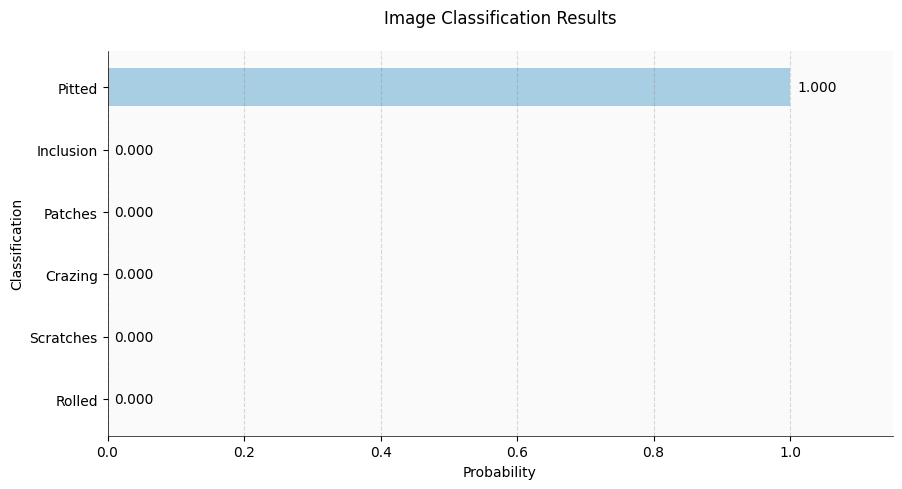

In [38]:
view_predictions()

In [39]:
print(f"Predicted tag is '{results[0]['tag']}' with score = {results[0]['probability']}")

Predicted tag is 'Pitted' with score = 1.0


## Webapp

In [53]:
def gradio_fn(image_file):
    """
    Process uploaded image and return classification predictions
    """
    start = time.time()
    predictions = classify_image(image_file)
    msg = f"[{datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}] Done in {(time.time() - start):.3f} seconds"

    return {item['tag']: item['probability'] for item in predictions}, msg

In [54]:
# Custom CSS for professional styling
custom_css = """
.gradio-container {
    max-width: 900px !important;
    margin: auto !important;
}
.header {
    text-align: center;
    margin-bottom: 30px;
}
.footer {
    text-align: center;
    margin-top: 30px;
    padding: 20px;
    color: #666;
    font-size: 14px;
}
"""

description = """
<div class="header">
    <h2>🧠 Metal defect classification</h2>
    <p>📤 Upload an image to classify it (⚡Powered by Azure Custom Vision). 
</p>
</div>
"""

In [57]:
webapp = gr.Interface(
    fn=gradio_fn,
    inputs=gr.Image(type="filepath",
                    label="📁 Upload an image",
                    elem_id="image_upload"),
    outputs=[
        gr.Label(num_top_classes=6,
                 label="🎯 Classification results",
                 elem_id="predictions_output"),
        gr.Textbox(label="⏱️ Status", 
                   interactive=False,
                   elem_id="elapsed_time")
    ],
    title="Image Classification with Azure Custom Vision",
    description=description,
    theme=gr.themes.Soft(
        primary_hue="blue",
        secondary_hue="gray",
        neutral_hue="slate",
    ),
    css=custom_css,
    analytics_enabled=False,
    examples=[
        ["gradio/metal_1.jpg"],
        ["gradio/metal_2.jpg"],
        ["gradio/metal_3.jpg"],
        ["gradio/metal_4.jpg"],
        ["gradio/metal_5.jpg"],
        ["gradio/metal_6.jpg"],
        ["gradio/metal_7.jpg"],
    ],
    submit_btn="CLASSIFY IMAGE",
    clear_btn="CLEAR",
)

webapp.launch(share=True)

* Running on local URL:  http://127.0.0.1:7869
* Running on public URL: https://ea5fd8f3e567d6e0f4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


🖼️ Image classification results of image file '/tmp/gradio/0de0d61b6f9fb03d3530313b2ef1fbd7ad6fc4fcdc947747fe597c0193b349a2/metal_6.jpg'
🏷️ Rolled = 0.8279971
🏷️ Scratches = 0.15939264
🏷️ Patches = 0.008396685
🏷️ Inclusion = 0.0036043588
🏷️ Pitted = 0.0005140834
🏷️ Crazing = 9.516636e-05

🖼️ Image classification results of image file '/tmp/gradio/c484dbeb20dc94bffa307ecf9e4ef67591635b5f40312dee775e5c3cea15bc88/metal_7.jpg'
🏷️ Scratches = 0.8598841
🏷️ Inclusion = 0.14002179
🏷️ Crazing = 8.6503365e-05
🏷️ Rolled = 5.7854963e-06
🏷️ Patches = 1.4409715e-06
🏷️ Pitted = 4.3173608e-07

🖼️ Image classification results of image file '/tmp/gradio/0de0d61b6f9fb03d3530313b2ef1fbd7ad6fc4fcdc947747fe597c0193b349a2/metal_6.jpg'
🏷️ Rolled = 0.8279971
🏷️ Scratches = 0.15939264
🏷️ Patches = 0.008396685
🏷️ Inclusion = 0.0036043588
🏷️ Pitted = 0.0005140834
🏷️ Crazing = 9.516636e-05

